# ANN Separating Data
- Creating a model to separate 3 sets of data based on color

In [95]:
# Importing Libraries
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display as dp
import sympy as sym
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Generating Data Function

In [96]:
def generate_data(nPerClust = 100, blur = 1, show_graph = True):

  """
  Creates three 2D Gaussian clusters (class A at (1,4), class B at (5,4), class C at (2.5,0))
  to be fed as input to a small feedforward net to classify points by color.

  Parameters:
  - nPerClust (int): Number of points per class. Default is 100.
  - blur (float): How spread out the data will be. Default is 1.
  - show_graph (bool): Whether to show the plot. Default is True.

  Returns: data, labels
  """

  # Creating The Data:
  n = nPerClust
  br = blur         # How spread out the data will be
  A = [1, 4]        # Centering Data A around coord- (1,4)
  B = [5, 4]        # Centering Data B around coord- (5,4)
  C = [2.5, 0]      # Centering Data C around coord- (2.5,0)

  # Generating Data:
  # 'a' and 'b' are lists of 2 arrays. One for abscissa and another for ordinate
  # The coordinates are randomly scattered by the factor "blur"
  a = [A[0]+np.random.randn(n)*br, A[1]+np.random.randn(n)*br]
  b = [B[0]+np.random.randn(n)*br, B[1]+np.random.randn(n)*br]
  c = [C[0]+np.random.randn(n)*br, C[1]+np.random.randn(n)*br]

  # True Labels
  # Vertically stacking data labels fo A, B, and C
  labels_np = np.vstack((np.zeros((n, 1)), np.ones((n, 1)), 2*np.ones((n, 1))))

  # Concatanate into a Matrix:
  # A 300x2 matrix is generated. Col 1 abscissa and Col 2 ordinate
  # 0:99 Data "a" // 100:199 Data "b" // 200:299 Data "c"
  data_np= np.hstack((a, b, c)).T

  # Convert to Tensors:
  data = torch.tensor(data_np).float()
  labels = torch.tensor(labels_np).float()

  # Showing the true data:
  fig = plt.figure(figsize=(5, 5))

  # Plotting the first 100 points as blue squares in the 1st zone:
  plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1],'bs')

  # Plotting the second 100 points as black circles in the 2nd zone:
  plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1],'ko')

  # Plotting the second 100 points as red triangles in the 3rd zone:
  plt.plot(data[np.where(labels==2)[0],0], data[np.where(labels==2)[0],1],'g^')

  if show_graph:
    plt.title('Data')
    plt.xlabel('dim 1')
    plt.ylabel('dim 2')
    plt.show()

  return data, labels

## Model Function

In [97]:
def model(data, learningRate, inpt = 2, out= 3, hidden_units = 1, multi_layer = True):
  """
  Creates and initializes a multi-class classification neural network with loss function and optimizer.

  Builds a feedforward network: Linear(2, h) → ReLU → Linear(h, 3), where h is the number
  of hidden units. Uses CrossEntropyLoss and SGD optimizer.

  Parameters:
  -----------
  data : torch.Tensor
      Input data tensor (shape: N×2). Used only for type conversion, not for training.
  learningRate : float
      Learning rate for SGD optimizer (e.g., 0.01, 0.1).
  inpt : int, optional
      Number of input features. Default is 2.
  out : int, optional
      Number of output classes. Default is 3.
  hidden_units : int, optional
      Number of hidden units in the network. Default is 1.

  Returns:
  --------
  ANNclassify : nn.Sequential
      The neural network model (2→h→3 architecture with ReLU).
  lossFunction : nn.CrossEntropyLoss
      Cross-entropy loss for multi-class classification.
  optimizer : torch.optim.SGD
      Stochastic gradient descent optimizer configured with the given learning rate.
  """

  # Building the Model
  data = data.float()
  h = hidden_units
  inp = inpt

  if not multi_layer:
    ANNclassify = nn.Sequential(
        nn.Linear(inp, h),    # Input layer (2 input, h output)
        nn.ReLU(),            # Activation Unit
        nn.Linear(h, out),    # Output Unit, changed from inp to out for 3 classes
    )
  else:
    ANNclassify = nn.Sequential(
        nn.Linear(inp,h),     # Input Layer
        nn.ReLU(),            # Activation
        nn.Linear(h,h),       # Hidden Layer
        nn.ReLU(),            # Activation
        nn.Linear(h,out),     # Output Layer
)


  # Loss Function
  lossFunction = nn.CrossEntropyLoss()       # Changed to CrossEntropyLoss for multi-class

  # Optimizer (Implementing Gradient Descent)
  optimizer = torch.optim.SGD(ANNclassify.parameters(), lr = learningRate)


  return ANNclassify, lossFunction, optimizer

## Model Trainer Function

In [98]:
def train_model(ANNclassify, lossFunction, optimizer, data, labels, \
                numepochs = 1000, show_graph=False, print_accuracy = False):
  """
  Trains a multi-class classification neural network using gradient descent.

  Performs forward pass, computes loss, backpropagates gradients, and updates
  model parameters for the specified number of epochs. Returns training history
  and final accuracy.

  Parameters:
  -----------
  ANNclassify : nn.Module
      The neural network model to train.
  lossFunction : nn.Module
      Loss function (typically nn.CrossEntropyLoss).
  optimizer : torch.optim.Optimizer
      Optimizer configured with model parameters and learning rate.
  data : torch.Tensor
      Input features (shape: N×2).
  labels : torch.Tensor
      Multi-class labels (shape: N, values 0, 1, or 2).
  numepochs : int, optional
      Number of training epochs. Default is 1000.
  show_graph : bool, optional
      If True, plots loss curve and highlights final loss. Default is False.
  print_accuracy : bool, optional
      If True, prints final accuracy to console. Default is False.

  Returns:
  --------
  losses : torch.Tensor
      Loss value at each epoch (shape: numepochs).
  predictions : torch.Tensor
      Final model predictions (logits) on training data (shape: N×3).
  totalacc : float
      Final accuracy percentage (0-100).
  acc : list
      List of accuracy values at each epoch.
  """

  # Training The Model:
  epochs = numepochs
  ann = ANNclassify
  data = data.float()
  acc = []
  losses = torch.zeros(epochs)

  for epochi in range(epochs):

    # Forward pass
    y_hat = ann(data)

    # Computing the loss
    loss = lossFunction(y_hat, labels)
    losses[epochi] = loss

    # Computing Accuracy
    matches = torch.argmax(y_hat, axis=1) == labels   # Boolean False/True
    matchesNumeric = matches.float()                  # Convert to 0/1
    accuracy = 100*torch.mean(matchesNumeric)         # Convert to %
    acc.append(accuracy)                              # Append to list

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  # Computing Predictions:
  predictions = ann(data) # Use ann to get predictions after training

  # Total Accuracy (for multi-class classification):
  # Get the predicted class by finding the index of the max logit
  predicted_labels = torch.argmax(predictions, dim=1)
  # Compare predicted labels with true labels
  totalacc = 100 * torch.mean((predicted_labels == labels).float())

  if show_graph:
      # Plotting the Losses:
      plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=.1)
      plt.plot(epochi, losses[-1].detach(), 'o', markerfacecolor='r', markersize=7)
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.title(f'Losses over Epochs, Final Accuracy {totalacc}%')
      plt.show()

  # Report Accuracy:
  if print_accuracy:
    print(f'Accuracy: {totalacc}%')
  return losses, predictions, totalacc, acc

## Code Test With 1 Iteration:

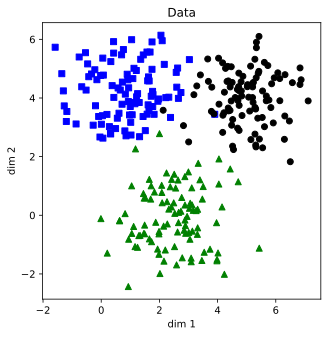

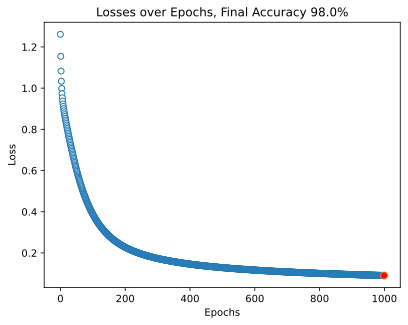

Accuracy: 98.0%


In [99]:
# Generating The Data:
data, labels = generate_data(show_graph=True)

# Convert labels to the correct format for CrossEntropyLoss
labels = labels.long().squeeze()

# Initializing The Model:
ANNclassify, lossFunction, optimizer = model(data, learningRate=0.01,\
                                             hidden_units = 64, multi_layer=True)

# Training The Model:
losses, predictions, totalacc, acc = train_model(ANNclassify, lossFunction,\
                                            optimizer, data, labels,\
                                            numepochs=1000, show_graph=True,\
                                            print_accuracy=True)

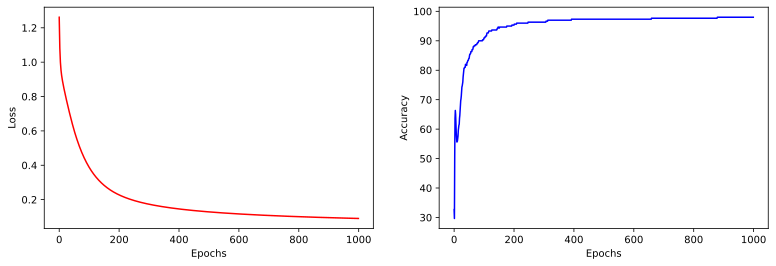

In [100]:
fig, ax = plt.subplots(1,2, figsize=(13,4))
ax[0].plot(losses.detach(), 'r-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(acc, 'b-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
plt.show()

## Visualizing Miss-match

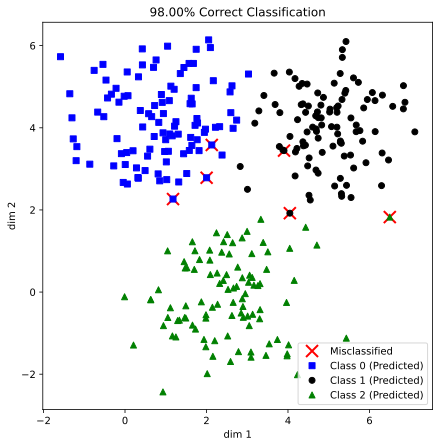

In [101]:
# Get predicted labels from the model's raw predictions (logits)
predicted_labels = torch.argmax(predictions, dim=1)

# Identify misclassified points
misclassified_idx = (predicted_labels != labels).nonzero(as_tuple=True)[0]

# Plot the Labeled Data:
fig = plt.figure(figsize=(7, 7))

# Plot misclassified points
plt.plot(data[misclassified_idx, 0], data[misclassified_idx, 1],\
         'rx', markersize=12, markeredgewidth=2.0, label='Misclassified')

# Plot correctly classified points for each class
plt.plot(data[np.where(predicted_labels == 0)[0], 0],\
         data[np.where(predicted_labels == 0)[0], 1],\
         'bs', label='Class 0 (Predicted)')

plt.plot(data[np.where(predicted_labels == 1)[0], 0],\
         data[np.where(predicted_labels == 1)[0], 1],\
         'ko', label='Class 1 (Predicted)')

plt.plot(data[np.where(predicted_labels == 2)[0], 0],\
         data[np.where(predicted_labels == 2)[0], 1],\
         'g^', label='Class 2 (Predicted)')

plt.legend()
plt.title(f'{totalacc:.2f}% Correct Classification')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.show()

## Experimenting The Model for Variable Learning Rates

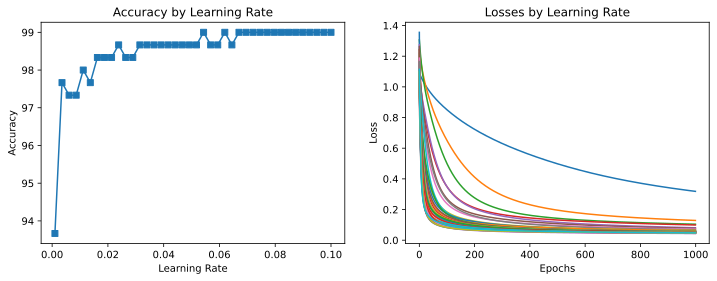

In [102]:
# Setting Learning Rates
learningrates = np.linspace(0.001, 0.1, 40)
numepochs = 1000

# Initializing Results
accByLr = []        # Accuracy per Learning Rate
allLosses = np.zeros((len(learningrates), numepochs))

# Running The Experiment
for i,lr in enumerate(learningrates):

  # Initializing The Model:
  ANNclassify, lossFunction, optimizer = model(data, lr, hidden_units = 64,\
                                               multi_layer=True)

  # Train The Model:
  losses, predictions, totalacc, acc = train_model(ANNclassify, lossFunction, \
                                              optimizer, data, labels, numepochs,\
                                              show_graph=False)

  # Storing All Results
  allLosses[i,:] = losses.detach().numpy()
  accByLr.append(totalacc.item())

# Plot the Labeled Data:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(learningrates, accByLr, 's-')
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by Learning Rate')

ax[1].plot(allLosses.T)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Losses by Learning Rate')
plt.show()

In [103]:
# Proportion of runs where accuracy exceeded 70%
sum(torch.tensor(accByLr) > 70)/len(accByLr)

tensor(1.)

## Meta-Experiment
Running a Meta-Experiment on the previous one conducted 50 times

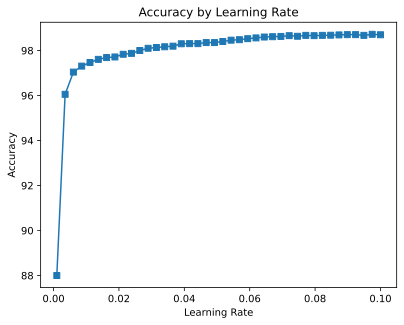

In [104]:
# Setting up outer loop.
numepochs = 500
meta_j = 50
learningrates = np.linspace(0.001, 0.1, 40)   # Setting Learning Rates

accMeta = np.zeros((meta_j, len(learningrates)))


for j in range(meta_j):

  # Running The Experiment
  for i,lr in enumerate(learningrates):

    # Initializing The Model:
    ANNclassify, lossFunction, optimizer = model(data, lr, multi_layer=True,\
                                                 hidden_units = 64)

    # Train The Model:
    losses, predictions, totalacc, acc = train_model(ANNclassify, lossFunction,\
                                                optimizer, data, labels,\
                                                numepochs, show_graph=False)

    # Storing All Results
    accMeta[j,i] = totalacc.item()


# Plotting The Results Averaged over experiments
plt.plot(learningrates, np.mean(accMeta, axis=0), 's-') # Average of acc along each column
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy by Learning Rate')
plt.show()